# Processing acoustic data with PAMGuide

This notebook demonstrates the use of PAMGuide for processing of passive acoustic data. PAMGuide, written by Nathan Merchant [ref], is available for both MATLAB and R.

This notebook has been created as a part of INTAROS.

Espen Storheim, NERSC. 2019-10-08.

### Setup
Initialization of PAMGuide is pretty simple.

In [1]:
# Check that the working directory is correct.
getwd()

[1] "/Users/espsto/Work/Projects/INTAROS/Cloud_Terradue/Jupyter_PAMGuide_test"

In [2]:
# Load the packages etc. from the main PAMGuide script. Need to run this command every time changes are made in PAMGuide.R.
source('PAMGuide.R')

### Usage
PAMGuide is written as a function with inputs. The inputs are described below. Also, refer to the user manual (ref) for more in-depth information.

### Example: Processing a demo sound clip
There are two test files (WAV-files) provided with PAMGuide:
* Sine\_10s\_48kHz\_+-0.5wav
* WhiteNoise\_10s\_48kHz\_+-0.5.wav

Both are recorded with a sampling frequency of 48 kHz, which corresponds to 48000 samples per second. 

File name: Sine_10s_48kHz_+-0.5.wav 
File length: 480000 samples = 10 s
Analysis type: PSD 
Plot type: Both 
Uncalibrated analysis. Output in relative units.
Time segment length: 48000 samples = 1 s
Window function: Hann 
Window overlap: 50 %
Loading input file... done in 0.033 s.
Computing PSD...done in 0.254 s.
Plotting...done in 0.131 s.
Computing noise level statistics...

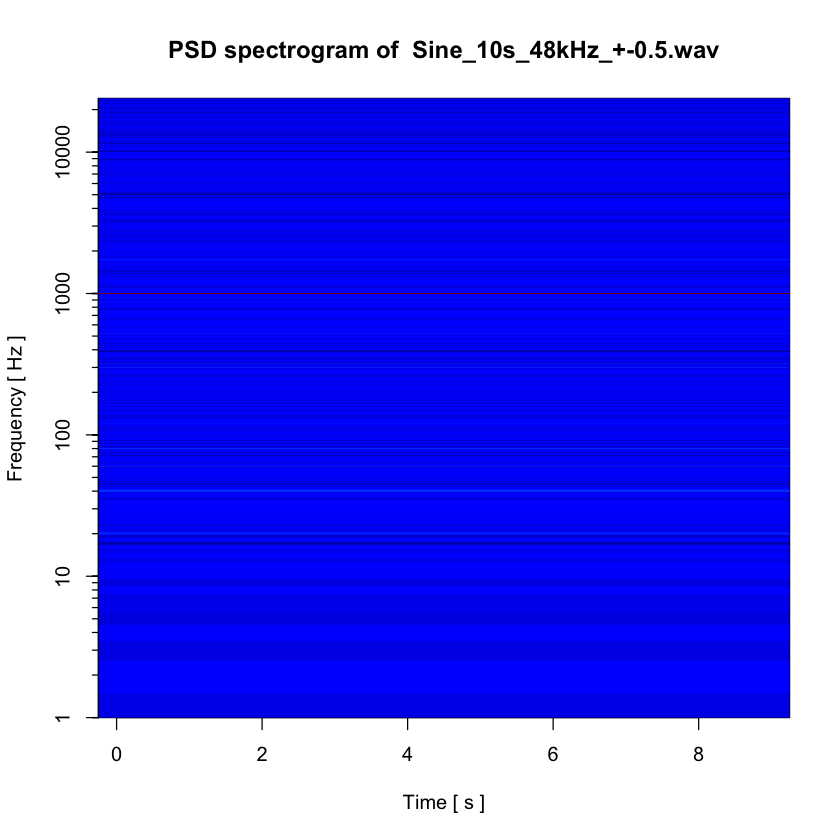

done in 2.597 s.
Too few time segments (M =  19 , i.e. <1000) for SPD analysis: for SPD, use a longer file or shorter time segment length (N).


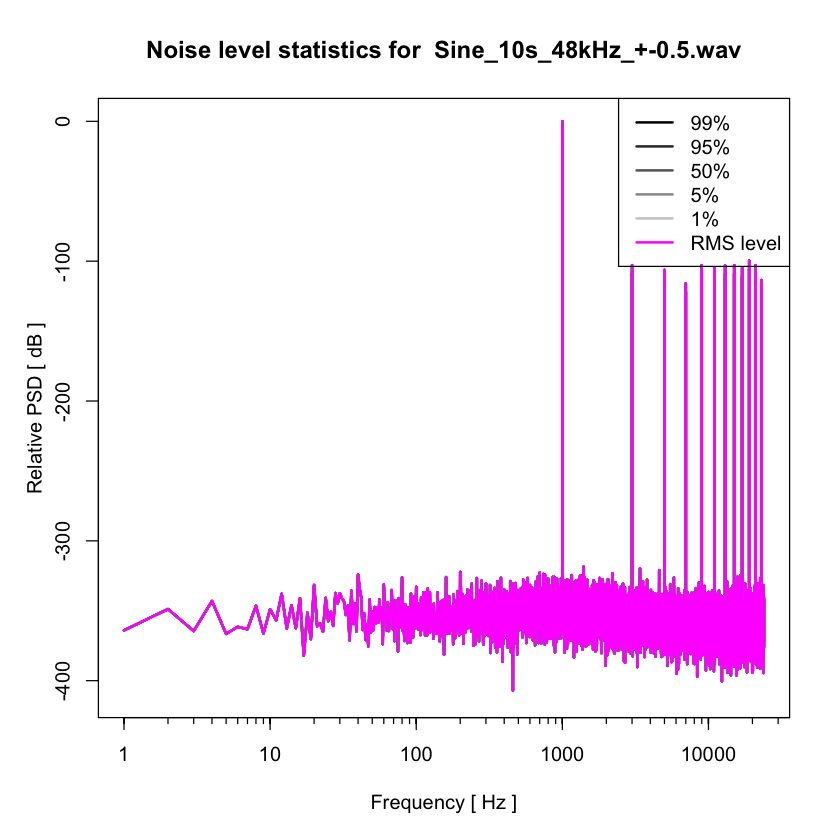

In [4]:
# Name of the input file:
ifname <- "Sine_10s_48kHz_+-0.5.wav"

# Analysis type:
atype <- "PSD"

# Plot type:
plottype <- "Both"

# Write a CSV output file:
outwrite <- 0

PAMGuide(fullfile=ifname, atype=atype, plottype=plottype)

### Example - Read data from a NetCDF file and apply calibration information

In this example, actual data and calibration information is used as input to PAMGuide.

In [7]:
require(ncdf4)
library(ncdf4)

Loading required package: ncdf4


In [8]:
# Name of the NetCDF file:
fname <- "rcv_238064010.nc"

In [10]:
# Open the NetCDF file for reading:
ncin <- nc_open(fname)
#$print(ncin)
#print(ncvar_get(ncin, "summary", verbose = F))



In [11]:
# Get attributes:
nc_atts <- ncatt_get(ncin,0)
#print(nc_atts)

print(nc_atts$summary)
print(nc_atts$data_assembly_center)

[1] "WIFAR/UNDER-ICE acoustic recording from an integrated ice station in the Fram Strait marginal ice zone"
[1] "CONSORTIA/INSTITUTIONS>>>>NERSC >Nansen Environmental and Remote Sensing Centre>http://www.nersc.no/main/index2.php"


In [12]:
# Sampling frequency [Hz]:
fs <- ncvar_get(ncin, "sample_rate", verbose = F)

# Time at start of recording:
t0 <- ncvar_get(ncin, "start_time", verbose = F)

# Samples:
y <- ncvar_get(ncin, "samples", verbose = F)

# Get the number of samples in the recording.
Nsamp <- length(y)



In [13]:
# Sensitivity of the hydrophone:
HySens <- -168 # dB re 1 uPa/V

# Gain of the voltage amplifier:
Gain <- 12 # dB re 1 V/V

# Digitizer information:
B2V <- 2.5/2^23 # Volt/Bit

In [14]:
# Convert from bits to pressure.
pressure <- y*10^(HySens/20)*10^(Gain/20)*B2V # Unit: Pascal [Pa]

In [15]:
# Set up the time vector from t0 with dt 
dt = 1/fs
t <- seq(0, Nsamp-1)*dt

#T0 <- as.POSIXct(t0, format = "%Y%m%dT%H%M%SZ", tz = "UTC")

Warning message in plot.xy(xy, type, ...):
“plot type 'lines' will be truncated to first character”

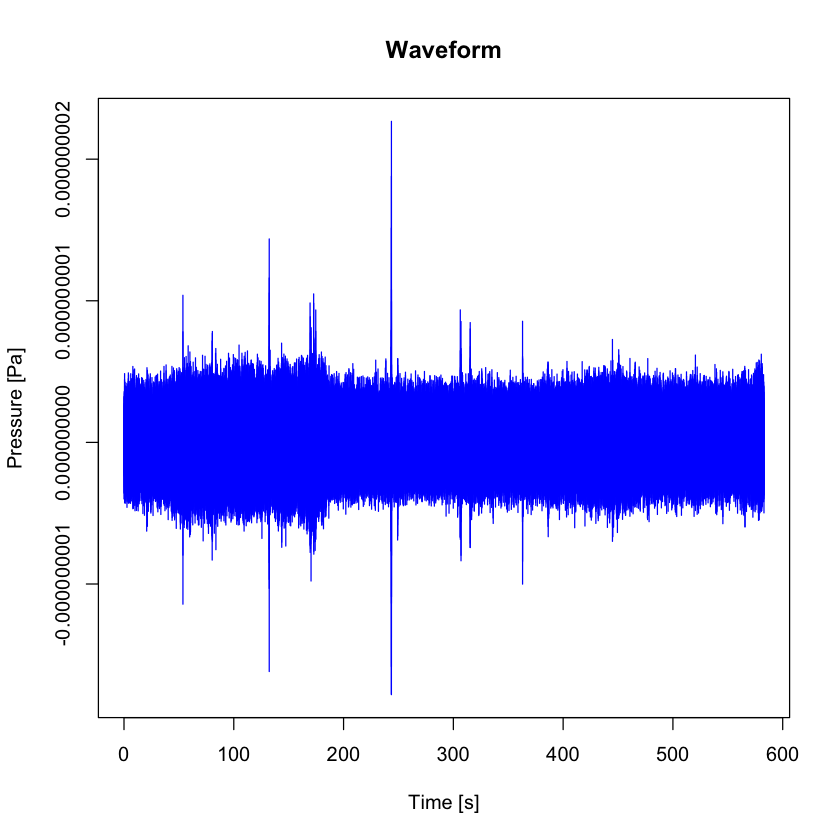

In [16]:
plot(t, pressure, col="blue",type="lines", main="Waveform", xlab="Time [s]", ylab="Pressure [Pa]")

In [19]:
PAMGuide(fullfile=fname, atype="TOL", plottype="Both", r=0.5, linlog="Lin",isvector=1, y=x, vADC=B2V )

ERROR: Error in readBin(con, int, n = 4, size = 1, endian = "little", signed = FALSE) %*% : non-conformable arguments
